../meshes/Mesh002/Outline_0_000.txt IS READ AND LOADED.


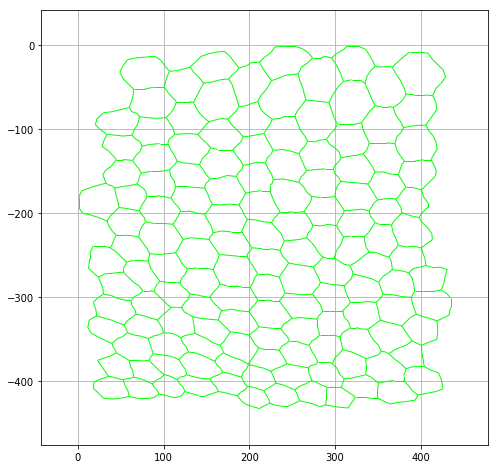

DONE...
Number of tensions =  349
Number of triple junctions = 219
---Tension solutions---
Mean = 0.997060487637422
Interval: [-0.028829, 5.504199]
Std = 0.6739806283491978


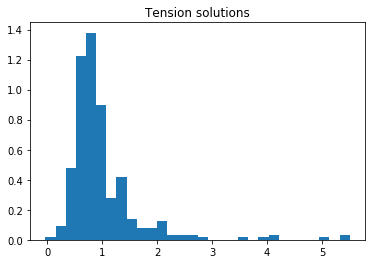

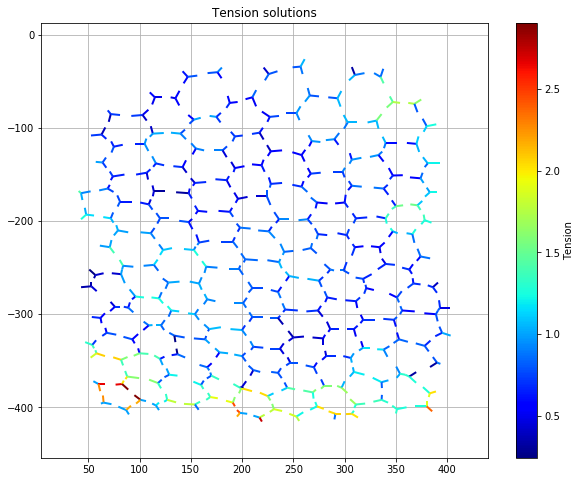

In [71]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 29 10:27:23 2019

@author: xj

Please enter full directory of the mesh text file.
Example: python solver.py mesh_file_name
"""

# =============================================================================
# IMPORT LIBRARIES
# =============================================================================
import sys
import math
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from numpy import where


# =============================================================================
# GLOBAL VARIABLES
# =============================================================================

STR_mesh_dir = '../meshes/Mesh002/Outline_0_000.txt' # directory path of FEM file

N_TJs = 0           # Number of triple junctions
N_Tens = 0          # Number of tensions
N_Edges = 0         # Number of edge segments
N_Edge_Groups = 0   # Number of edge groups (tensions)
N_Cells = 0         # Number of cells

ID_Nodes = []       # List of node IDs
ID_TJs = []         # List of triple junction IDs
ID_TJ_Edges = []    # List of edges associated with TJs
ID_TJ_Edges_U = []  # List of unique edges associated with TJs
ID_Cells = []       # List of Cell IDs

# Spatial information
S_All_Nodes = []    # [x, y, edge1, edge2]
S_TJ_Edge_Vecs = [] # 6 by N_TJ list of direction vectors 
                    # [[vec1x, vec1y, vec2x, vec2y, vec3x, vec3y], [], ...]
S_Rho = []          # list of radius of curvatures
S_p0 = []           # list of coordinates of circle centers [[x,y], [], ...]

# Maps of things
MAP_Edge_Nodes = []     # [[edge ID, node1 ID, node2 ID], [], ...] for all nodes
MAP_U_Edge_Nodes = []   # [[edge ID, node1 ID, node2 ID], [], ...] for nodes on unique edges
MAP_Edgegroup_Nodes = []# [[edge ID, node1 ID, node2 ID], [], ...] for nodes on edgegroups
MAP_TJ_Edge_Nodes = []  # for TJ nodes
MAP_Edge_to_Ten = []    # maps edge id to unique tension number
MAP_Edge_Cells = []     # [[Edge_ID, Cell_1_ID, Cell_2_ID], [], ...]

# Visualization information
GRAPH_All_Edges = []
GRAPH_TJ_Edges = []

# =============================================================================
# FUNCTIONS
# =============================================================================

def FNC_Read_Mesh():
    """
    Parse the mesh .txt file (STR_mesh_dir) and populate 
    the global variables with information.
    02/07/19:
    solver.ipynb uses the 'with open()' statement 5 times.
    Trying to optimize parsing.
    02/16/19:
    Reduced it to ___ 'with open()' statements
    """
    global STR_mesh_dir
    global ID_Nodes, ID_TJs, ID_TJ_Edges
    global S_TJ_Edge_Vecs, S_All_Nodes
    global MAP_Edge_Nodes, MAP_U_Edge_Nodes
    global MAP_Edgegroup_Nodes, MAP_Edge_Cells
    global S_Rho, S_p0
    
    with open(STR_mesh_dir, 'r') as df:
        flag_nodes = False
        for line in df:
            # Read node info between BEGIN_NODES -> BEGIN_ALLEDGES
            if 'BEGIN_NODES' in line:
                flag_nodes = True
                continue
            if 'BEGIN_ALLEDGES' in line:
                flag_nodes = False
            if flag_nodes == True:
                elements = line.split('\t')
                try:
                    ID_Nodes.append(int(elements[0]))
                    S_All_Nodes.append([
                            int(elements[0]),
                            float(elements[1]),
                            float(elements[2]),
                            int(elements[-4]),
                            int(elements[-3])])
                except:
                    continue
            if 'Vec1' in line:  # Select TJs by using 'Vec1' as a filter  
                elements = line.split('\t')
                ID_TJs.append(int(elements[0])) # node ID
                try:
                    S_TJ_Edge_Vecs.append([ # Vec(r*cos(theta), r*sin(theta))
                            float(elements[5].split(' ')[1]),
                            float(elements[5].split(' ')[2]),
                            float(elements[6].split(' ')[1]),
                            float(elements[6].split(' ')[2]),
                            float(elements[7].split(' ')[1]),
                            float(elements[7].split(' ')[2])])
                except:
                    print('ERROR: MISSING DIRECTION VECTORS \
                          AT NODE %d'%int(elements[0]))
                    S_TJ_Edge_Vecs.append([
                            float(elements[5].split(' ')[1]),
                            float(elements[5].split(' ')[2]),
                            float(elements[6].split(' ')[1]),
                            float(elements[6].split(' ')[2]),
                            0,
                            0]) 
                ID_TJ_Edges.append(int(elements[9]))
                ID_TJ_Edges.append(int(elements[10]))
                ID_TJ_Edges.append(int(elements[11]))
            # Read edge info between BEGIN_ALLEDGES -> BEGIN_EDGEGROUPS
            if 'Edge2D' in line:
                elements = line.split('\t')
                MAP_Edge_Nodes.append([
                        int(elements[0]),
                        int(elements[2]),
                        int(elements[3])])
    
    with open(STR_mesh_dir, 'r') as df:
        for line in df:
            if 'Edge2D' in line:
                elements = line.split('\t')
                if int(elements[0]) in ID_TJ_Edges:
                    MAP_U_Edge_Nodes.append([int(elements[0]), int(elements[2]), int(elements[3])])
    
    with open(STR_mesh_dir, 'r') as df:
        flag = False
        for line in df:
            if 'BEGIN_EDGEGROUPS' in line:
                flag = True
                continue
            if 'BEGIN_ALLFACES' in line:
                break
            if flag:
                elements = line.split('\t')
                #print(int(elements[2].split(' ')[0]), int(elements[2].split(' ')[1]))
                try:
                    if (int(elements[2].split(' ')[0]) == 10000001 
                            or int(elements[2].split(' ')[1]) == 10000001):
                           continue
                    if 'Circle' in elements[4]:
                        MAP_Edgegroup_Nodes.append([int(elements[0]), 
                                               int(elements[1].split(' ')[0]),
                                               int(elements[1].split(' ')[1])])
                        MAP_Edge_Cells.append([int(elements[0]), 
                                               int(elements[2].split(' ')[0]),
                                               int(elements[2].split(' ')[1])])
                        S_Rho.append(float(elements[4].split(' ')[1]))
                        S_p0.append([float(elements[4].split(' ')[2]),
                                        float(elements[4].split(' ')[3])])
                    if 'Line' in elements[4]:
                        MAP_Edgegroup_Nodes.append([int(elements[0]), 
                                               int(elements[1].split(' ')[0]),
                                               int(elements[1].split(' ')[1])])
                        MAP_Edge_Cells.append([int(elements[0]), 
                                               int(elements[2].split(' ')[0]),
                                               int(elements[2].split(' ')[1])])
                        S_Rho.append(-1) # -1 for cell-cell boundaries that are lines
                        S_p0.append([-1,-1])

                except:
                    #print('PARSING ERROR: EDGEGROUP INFO CANNOT BE READ.')
                    continue
    
def FNC_Fill_Mesh_Info():
    """
    Calculate or formulate other mesh information.
    Repeated TJ edges are due to short edge groups.
    # LIST_Unique_TJ_Edges was needed but I've chosen to simply update
    # ID_TJ_Edges and encapsulating the crap
    """
    global N_TJs
    global ID_TJ_Edges
    global ID_TJ_Edges_U
    global MAP_TJ_Edge_Nodes
    global GRAPH_All_Edges
    global GRAPH_TJ_Edges

    ID_TJ_Edges_U = list(set(ID_TJ_Edges)) # Removes repeated TJ edge IDs
    
    for edge in MAP_Edge_Nodes:
        if edge[0] in ID_TJ_Edges:
            MAP_TJ_Edge_Nodes.append(edge)
            
    N_TJs = len(ID_TJs) # number of TJs = number of TJ IDs
    
    for i in range(len(MAP_Edge_Nodes)): 
        ind0 = ID_Nodes.index(MAP_Edge_Nodes[i][1])
        ind1 = ID_Nodes.index(MAP_Edge_Nodes[i][2])        
        GRAPH_All_Edges.append([
                (S_All_Nodes[ind0][1], S_All_Nodes[ind0][2]),
                (S_All_Nodes[ind1][1], S_All_Nodes[ind1][2])])
    
    for i in range(len(MAP_TJ_Edge_Nodes)): 
        ind0 = ID_Nodes.index(MAP_TJ_Edge_Nodes[i][1])
        ind1 = ID_Nodes.index(MAP_TJ_Edge_Nodes[i][2])
        GRAPH_TJ_Edges.append([
                (S_All_Nodes[ind0][1], S_All_Nodes[ind0][2]),
                (S_All_Nodes[ind1][1], S_All_Nodes[ind1][2])])

def FNC_Vis_Mesh(GRAPH):
    """
    Plots the FEM file to visualize the image in vector form.
    """
    c = np.array([(0, 1, 0, 1)]) #(1, 0, 0, 1), (0, 0, 1, 1)
    lc = mc.LineCollection(GRAPH, colors=c, linewidths=1)
    fig, ax = pl.subplots(figsize=(8,8))
    ax.add_collection(lc)
    plt.grid()
    ax.margins(0.1)
    plt.show()


def FNC_Create_Map_Edge_to_Ten(ID_TJ_Edges,
                               Edges_Nodes, 
                               ID_TJ,
                               LIST_All_Nodes,
                               LIST_All_Edge_Nodes):
    """
    Creates a list that maps a given TJ edge to an unique tension ID.
    """
    global MAP_Edge_to_Ten, N_Tens
    i_Ten = 0
    LIST_Unique_Edges_Nodes = np.array(Edges_Nodes)
    LIST_All_Nodes = np.array(LIST_All_Nodes)
    LIST_All_Edge_Nodes = np.array(LIST_All_Edge_Nodes)
    prog = 1
    for edge_ind1 in ID_TJ_Edges: 
        tj1 = False
        tj2 = False
        edge_ind2 = edge_ind1
        node1 = LIST_Unique_Edges_Nodes[where(edge_ind1 == LIST_Unique_Edges_Nodes[:,0])[0][0], 1]
        node2 = LIST_Unique_Edges_Nodes[where(edge_ind1 == LIST_Unique_Edges_Nodes[:,0])[0][0], 2]
        # check for existence in MAP_Edge_to_Ten to avoid double counting
        if edge_ind1 in [item[0] for item in MAP_Edge_to_Ten]: continue

        for itr in range(10):
            if node1 in ID_TJ:
                tj1 = True
            else: # find the edge connects to the other tj
                newedge1 = LIST_All_Nodes[where(node1 == LIST_All_Nodes[:,0])[0][0], -2]
                newedge2 = LIST_All_Nodes[where(node1 == LIST_All_Nodes[:,0])[0][0], -1]
                if newedge1 != edge_ind2:
                    edge_ind2 = newedge1
                    newnode1 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 1]
                    newnode2 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 2]
                    if newnode1 != node1:
                        node1 = newnode1
                    else:
                        node1 = newnode2
                else:
                    edge_ind2 = newedge2
                    newnode1 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 1]
                    newnode2 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 2]
                    if newnode1 != node1:
                        node1 = newnode1
                    else:
                        node1 = newnode2
       
            if node2 in ID_TJ:
                tj2 = True
            else: # find the edge connects to the other tj
                newedge1 = LIST_All_Nodes[where(node2 == LIST_All_Nodes[:,0])[0][0], -2]
                newedge2 = LIST_All_Nodes[where(node2 == LIST_All_Nodes[:,0])[0][0], -1]
                if newedge1 != edge_ind2:
                    edge_ind2 = newedge1
                    newnode1 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 1]
                    newnode2 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 2]
                    if newnode1 != node2:
                        node2 = newnode1
                    else:
                        node2 = newnode2
                else:
                    edge_ind2 = newedge2
                    newnode1 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 1]
                    newnode2 = LIST_All_Edge_Nodes[where(edge_ind2 == LIST_All_Edge_Nodes[:,0])[0][0], 2]
                    if newnode1 != node2:
                        node2 = newnode1
                    else:
                        node2 = newnode2
  
            if tj1 and tj2:
                # record the two edge inds and map them to the same tension ind
                MAP_Edge_to_Ten.append([edge_ind1, i_Ten])
                MAP_Edge_to_Ten.append([edge_ind2, i_Ten])
                break
        else: # search is out of bounds - edge pointing away from region of interest
            MAP_Edge_to_Ten.append([edge_ind1, i_Ten])
        i_Ten += 1
    
    MAP_Edge_to_Ten = np.array(MAP_Edge_to_Ten, dtype=int)
    N_Tens = i_Ten
    print('DONE...')
    print('Number of tensions = ', i_Ten)
    print('Number of triple junctions =', len(ID_TJ))
    

def FNC_Map_Edge_to_Tension(Edge_ID):
    """
    Takes in an edge ID and returns the tension ID
    Caveat: only works for the triple junction edge segments
    Bug: Exception error when edge ID of non-TJ edge is passed
    Improve: make it work for all edges
    """
    global MAP_Edge_to_Ten
    try:
        ind = where(Edge_ID == MAP_Edge_to_Ten[:,0])[0][0]
        return MAP_Edge_to_Ten[ind, 1]
    except:
        print('EXCEPTION ERROR: EDGE ID NOT FOUND')
        return float('nan')

def FNC_Lstsq_Tensions():
    """
    Calculates the tensions using a constrained least-squares system.
    """
    global N_Tens, N_TJs, S_TJ_Edge_Vecs, ID_TJ_Edges
    G = np.mat(np.zeros((N_Tens, 2*N_TJs)))
    A = np.zeros((N_Tens+1, N_Tens+1))
    b = np.zeros(N_Tens+1)
    A[:-1,-1] = 1
    A[-1,:-1] = 1
    b[-1] = N_Tens
    for i in range(N_TJs):
        for vec in range(3):
            norm = np.sqrt(S_TJ_Edge_Vecs[i][2*vec]**2 + S_TJ_Edge_Vecs[i][2*vec + 1]**2)
            col = FNC_Map_Edge_to_Tension(ID_TJ_Edges[3*i + vec])
            G[col, 2*i] = S_TJ_Edge_Vecs[i][2*vec] / norm
            G[col, 2*i + 1] = S_TJ_Edge_Vecs[i][2*vec + 1] / norm
    C = 2*np.matmul(G, G.T)
    A[:-1,:-1] = C

    print('---Tension solutions---')
    gamma = np.linalg.solve(A, b)
    print('Mean =', gamma.mean())
    print('Interval: [%f, %f]'%(gamma.min(), gamma.max()))
    print('Std =', gamma.std())
    plt.hist(gamma, bins=30, density=True)
    plt.title('Tension solutions')

    return gamma
    
def FNC_Visualize_Tensions(gamma_p):
    """
    gamma_p[numpy.ndarray]: tension solutions to visualize
    """
    global MAP_U_Edge_Nodes, S_All_Nodes
    
    graph = []
    ind_node = np.array(S_All_Nodes)[:,0]
    for i in range(len(MAP_U_Edge_Nodes)): 
        ind0 = where(ind_node == MAP_U_Edge_Nodes[i][1])[0][0]
        ind1 = where(ind_node == MAP_U_Edge_Nodes[i][2])[0][0]
        graph.append([(S_All_Nodes[ind0][1], S_All_Nodes[ind0][2]),
                  (S_All_Nodes[ind1][1], S_All_Nodes[ind1][2])])
    # get rid of spikes
    for i in range(len(gamma_p)):
        if gamma_p[i] > 3: gamma_p[i] = 1

    # 1. Create a plot with correctly matched tension values for just the tj edges
    colorvalues = []
    for i in range(len(graph)):
        colorvalues.append(gamma_p[FNC_Map_Edge_to_Tension(MAP_U_Edge_Nodes[i][0])])
    colorvalues = np.array(colorvalues)
    lc = mc.LineCollection(graph, array=colorvalues, cmap=plt.cm.jet, linewidths=2)
    fig, ax = pl.subplots(figsize=(10,8))
    ax.add_collection(lc)
    plt.title('Tension solutions')
    plt.grid()
    ax.margins(0.1)

    # 2. Append a color scale that is sensible and labelled
    I = cm.ScalarMappable(norm=None, cmap='jet')
    I.set_array(colorvalues)
    axcb = fig.colorbar(I)
    axcb.set_label('Tension')
    #plt.scatter(X, Y, s=15, marker='o', color='black')

    plt.show()

def FNC_Writetofile(filename, results):
    """
    filename: string
    results: array
    Prints results to txt file with the given name.
    Dependencies: global variable MAP_Edge_to_Ten
    """
    f = open(filename, 'w')
    f.write('Tension                 Associated edges\n')
    for i in range(len(results)):
        ass_edges = where(i == MAP_Edge_to_Ten[:,1])[0]
        f.write(str(results[i])+'\t'+str(ass_edges)+'\n')
    f.close()

def FNC_Check_Gp_matrix(Gp):
    """
    Check for potential errors in the Gp matric
    """
    # check for zero columns
    for i in range(Gp.shape[1]):
        sum = 0
        for j in range(Gp.shape[0]):
            sum += abs(Gp[j,i])
        #print(i, sum)
        if sum == 0:
            print('Zero column at', i)
            print(Gp[:,i])
    # check for identical rows
    for i in range(Ap.shape[0]):
        for j in range(i + 1, Ap.shape[0]):
            aa = Ap[:,i] - Ap[:,j]
            #print(aa)
            sum = 0
            for k in aa:
                sum += abs(k)
            if sum == 0:
                print('Identical column found at', i,j)
    print('Gp matrix checked.')

def FNC_Cal_CP():
    """
    Calculates all the cross products for each
    edgegroup for the purpose of determining 1 and -1
    in the Gp matrix.
    """
    global N_Tens, S_All_Nodes, MAP_Edgegroup_Nodes
    LIST_v1 = np.zeros((2,N_Tens)) # vector p0 to p1
    LIST_v2 = np.zeros((2,N_Tens)) # vector p0 to p2
    LIST_crossp = np.zeros(N_Tens) # 1 denotes counter-clockwise
                                  # -1 denotes clockwise
    LIST_Mid_Nodes = np.zeros((2,N_Ten), dtype=int) # index of nodes that considered as p1 and p2 (make up the edge)

    for i in range(N_Ten):
        try:
            p1_ind = where(MAP_Edgegroup_Nodes[i][1] == S_All_Nodes[:,0])[0][0] # node index of p1
            p2_ind = where(MAP_Edgegroup_Nodes[i][2] == S_All_Nodes[:,0])[0][0] # node index of p2
            LIST_Mid_Nodes[0,i] = p1_ind
            LIST_Mid_Nodes[1,i] = p2_ind
        except:
            print("ERROR", 'Node_IDs', LIST_Edge_Node[i][1], LIST_Edge_Node[i][2])
            continue
        p0x, p0y = LIST_p0[i][0], LIST_p0[i][1]
        LIST_v1[0, i], LIST_v1[1, i] = LIST_All_Nodes[p1_ind, 1] - p0x, LIST_All_Nodes[p1_ind, 2] - p0y
        LIST_v2[0, i], LIST_v2[1, i] = LIST_All_Nodes[p2_ind, 1] - p0x, LIST_All_Nodes[p2_ind, 2] - p0y
        LIST_crossp[i] = np.sign(LIST_v1[0, i] * LIST_v2[1, i] - LIST_v1[1, i] * LIST_v2[0, i])
    
    return LIST_crossp

# =============================================================================
# MAIN FUNCTIONS
# =============================================================================
    
def FNC_Mesh():
    """
    """
    FNC_Read_Mesh()
    FNC_Fill_Mesh_Info()
    print('%s IS READ AND LOADED.'%STR_mesh_dir)
    FNC_Vis_Mesh(GRAPH_All_Edges)
    
def FNC_Cal_Tension():
    """
    """
    FNC_Create_Map_Edge_to_Ten(ID_TJ_Edges, MAP_Edge_Nodes, 
                               ID_TJs, S_All_Nodes, MAP_Edge_Nodes)
    Ten_Soln = FNC_Lstsq_Tensions()
    # prompt to save results in text file
    FNC_Visualize_Tensions(Ten_Soln)

def FNC_Cal_Pressure():
    """
    """
    CrossProducts = FNC_Cal_CP()


def main():
    """
    
    """
    FNC_Mesh()
    FNC_Cal_Tension()
    FNC_Cal_Pressure()


main()